# Graph Transformer

## Prelim

In [7]:
import torch
import dgl
from torch import nn
import torch.nn.functional as Fn
from dgl import function as fn
import numpy as np
import seaborn as sns
from matplotlib import pylab as plt

## Standard Mult-Head Attention using Torch

In [106]:
# say we have our three linear embeddings of query, key, and value
# it is assumed the dimensions between key and value are equivalent
q = torch.randn(10, 4, 30)
k = torch.randn(10, 3, 30)
v = torch.randn(10, 3, 30)

# Attention is generally applied with QK^TV, often with scaling and softmax applied,
# as in softmax(scaling * QK^T)V
print(torch.matmul(torch.matmul(q, k.transpose(-2, -1)), v).shape)


# to do multihead attention, we split the tensor across multiple heads
# we first calculate some dimensions
batch_size = q.size(0)
d_model = q.size(-1)
heads = 5
d_k = d_model // heads

# else we need to change our embeddings a bit
assert d_model % heads == 0

# then we split d_model across multiple heads
q_view = q.view(batch_size, -1, heads, d_k)

# we then swap the head to the non-matrix (i.e. batch) dimensions using transpose
q_view = q_view.transpose(1, 2)

# NOTE: it must be done in this was as not to juggle the values

# resulting in (batch_size, h, i, d_k)
# our aim is to sum across d_k during matrix multiplication, so that (b, h, i, d_k) * (b, h, d_k, j) -> (b, h, i, j)
# final matmul with the value results in (b, h, i, j) * (b, h, j, d_k) -> (b, h, j, d_k)
q_view = q.view(batch_size, -1, heads, d_k).transpose(1, 2)
k_view = k.view(batch_size, -1, heads, d_k).transpose(1, 2)
v_view = v.view(batch_size, -1, heads, d_k).transpose(1, 2)
    
z = torch.matmul(q_view, k_view.transpose(-2, -1))
print(z.shape)

# the attention as a specific head (e.g. batch=0, head=1) can be found using:
print(z[0, 1])

# out final values with attenion applied
a = torch.matmul(z, v_view)

# which returns us to the original shape
a.view(batch_size, -1, heads * d_k).shape

torch.Size([10, 4, 30])
torch.Size([10, 5, 4, 3])
tensor([[-1.4903, -0.0961, -2.0008],
        [-1.3389,  0.4778, -1.3547],
        [ 0.8485,  3.0928, -1.0279],
        [-3.8352, -1.1507,  2.7676]])


torch.Size([10, 4, 30])

We can quickly implement the initial embedding of the MultiHeadAttention. Right now, we are leaving out the more complicated forward propogation. We will walk through that implementation next.

In [471]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, h, dim_model):
        super().__init__()
        self.d_k = dim_model // h
        assert dim_model % h == 0
        self.h = h
        # W_q, W_k, W_v, W_o
        self.linears = clones(nn.Linear(dim_model, dim_model), 4)
        
    def get(self, x, fields='qkv'):
        "Return a dict of queries / keys / values."
        batch_size = x.shape[0]
        ret = {}
        if 'q' in fields:
            ret['q'] = self.linears[0](x).view(batch_size, self.h, self.d_k)
        if 'k' in fields:
            ret['k'] = self.linears[1](x).view(batch_size, self.h, self.d_k)
        if 'v' in fields:
            ret['v'] = self.linears[2](x).view(batch_size, self.h, self.d_k)
        return ret
    
    def get_output(self, x):
        "get output of the multi-head attention"
        batch_size = x.shape[0]
        return self.linvears[3](x.view(batch_size, -1))

Graph(num_nodes=5, num_edges=4,
      ndata_schemes={'k': Scheme(shape=(12,), dtype=torch.float32), 'q': Scheme(shape=(12,), dtype=torch.float32), 'v': Scheme(shape=(12,), dtype=torch.float32)}
      edata_schemes={})


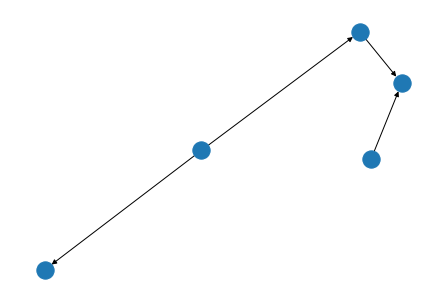

In [472]:
import dgl
import dgl.function as fn # contains all the built-in optimized message passing and reduce functions.
import networkx as nx
%matplotlib inline

def init_g(d_k):
    g = dgl.graph(([0, 0, 2, 3], [1, 2, 4, 4]))
    n = g.number_of_nodes()
    g.ndata['k'] = torch.randn(n, d_k)
    g.ndata['q'] = torch.randn(n, d_k)
    g.ndata['v'] = torch.randn(n, d_k)
    return g

g = init_g(12)

nxg = nx.DiGraph(g.to_networkx())
print(g)
nx.draw(nxg)

## Utils

In [543]:
# plotting utils

def to_nxg(g: dgl.DGLGraph) -> nx.DiGraph:
    nxg = nx.DiGraph(g.to_networkx())
    return nxg
    
def plot_graph(g: dgl.DGLGraph, ax=None, **kwargs):
    nxg = to_nxg(g)
    pos = nx.nx_agraph.pygraphviz_layout(nxg, prog='neato')
    nx.draw(nxg, pos=pos, ax=ax, **kwargs)
    return ax
    
def attn_to_sparse(g: dgl.DGLGraph, attn: torch.Tensor):
    n = g.number_of_nodes()
    i = torch.stack(g.edges())
    v = attn
    x = torch.sparse_coo_tensor(i, v.flatten(), (n, n))
    return x

def plot_attn(g: dgl.DGLGraph, attn: torch.Tensor, ax=None):
    x = attn_to_sparse(g, attn)
    sns.heatmap(x.to_dense().numpy(), ax=ax)

def plot_graph_and_attn(g: dgl.DGLGraph, attn: torch.Tensor):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    axes[0].set_title("Graph")
    axes[1].set_title("Attention")
    plot_graph(g, ax=axes[0], width=attn.flatten().numpy())
    plot_attn(g, attn, ax=axes[1])

## Attention layer of Graph Transformer

The **attention** layer, each node in module learns to assign weights on its incoming edges. For node pair $(i,j)$ with node $x_i,x_j \in \mathbb{R}^n$, the score of connection is as follows:

$$
q_j = W_q \cdot x_j \\
k_i = W_k \cdot x_i \\
v_i = W_v \cdot x_i \\
\text{score} = q_j k_i^\top
$$

$W_q, W_k, W_v \in \mathbb{R}^{n \times d_k}$ map the representations of x to "query", "key", and "value" space repsectively. These values are three different linear projections of the data. For the "query" case ($W_j$), these are linear projections of source nodes for edges. For "key" and "value", were are linear projections of the destination nodes. The dot product between query source nodes and key destination nodes computes the score of the given connection.

$$
\text{Attention}(Q, K, V) = \text{Softmax}\Bigg(\frac{QK^\top}{\sqrt{d_k}}\Bigg)V
$$


### Attention: Using Torch

tensor([[1.0000],
        [1.0000],
        [0.5805],
        [0.4195]])


<ipython-input-523-56177758f41a>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score = F.softmax(_z / scale)


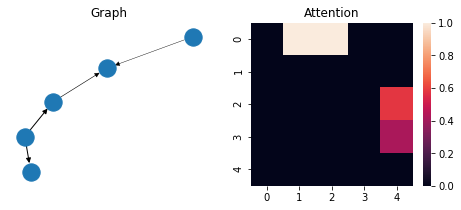

In [523]:
def attention(g):
    attention_arrs = []
    score_arrs = []
    
    q = g.ndata['q']
    d_k = q.size(-1)
    scale = d_k**0.5
    n = g.number_of_nodes()
    for i in range(n):
        idx = torch.where(g.edges()[1] == i)[0]
        src = g.edges()[0][idx]
        dst = g.edges()[1][idx]
        src = torch.tensor(list(set(src.tolist())), dtype=torch.long)
        dst = torch.tensor(list(set(dst.tolist())), dtype=torch.long)

        # dst
        q = g.ndata['q'][dst]

        #src
        k = g.ndata['k'][src]
        v = g.ndata['v'][src]
        _z = torch.matmul(q, k.transpose(-2, -1))
        
        score = F.softmax(_z / scale)
        out = torch.matmul(score, v)
        if out.size(0) == 0:
            out = torch.zeros_like(g.ndata['q'][:1])
        attention_arrs.append(out)
        score_arrs.append(score)

    attention = torch.cat(attention_arrs)
    score = torch.cat([s.T for s in score_arrs if s.size(0)], 0)
    return attention, score

g = init_g(3)
out, attn = attention(g)
print(attn)
plot_graph_and_attn(g, attn)

### Attention: With standard message passing
Now we will walk through the forward propogation using dgl. First, lets create a simple test graph and attach some data to the nodes. Note, however, we cannot appropriately apply edge softmax.

In [545]:
# example: applying basic matmul qk^T in dgl

# initialize graph
g = init_g(3)
print(g.edges())

# lets run attention on edges (2, 4), (3, 4)
i = torch.tensor([0, 1])
src = g.edges()[0][i]
dst = g.edges()[1][i]

# we only look at unique edges
src = torch.tensor(list(set(src.tolist())))
dst = torch.tensor(list(set(dst.tolist())))
print(src, dst)

# filter the data
k = g.ndata['k'][src]
v = g.ndata['v'][src]
q = g.ndata['q'][dst]

# apply matmul in non-graph version
# for mxn, expect a mxm matrix
_z = torch.matmul(q, k.transpose(-2, -1))
print(_z)

# dgl version
with g.local_scope():
    g.apply_edges(fn.v_mul_u('q', 'k', '_z'))
    print('\nEdge Messages: a \'n_edge x d_model\'')
    print(g.edata['_z'])
    print(g.edata['_z'].sum(1))

# typical message passing would take the messages on each edge
# and for every node, sum incoming message. For attention,
# we just want to sum across d_k. We may want to optimize
# this by creating a corresponding kernel to combine this operation.
# We therefore create a new user defined function.
print("\nNote this is different from the typical message passing paradigm, which sums incoming edges.")
with g.local_scope():
    g.update_all(fn.v_mul_u('q', 'k', '_z'), fn.sum('_z', 'score'))
    print(g.ndata['score'])
    
# `v_dot_u` will perform these same operations concisely
print("\nHowever, the most concise was is to use the `v_dot_u` operator, followed by sum as this fuses the kernels")
with g.local_scope():
    g.apply_edges(fn.v_dot_u('q', 'k', '_z'))
    print(g.edata['_z'])

(tensor([0, 0, 2, 3]), tensor([1, 2, 4, 4]))
tensor([0]) tensor([1, 2])
tensor([[-3.9549],
        [ 0.9090]])

Edge Messages: a 'n_edge x d_model'
tensor([[-2.5269, -1.0795, -0.3486],
        [ 1.0945, -0.5738,  0.3882],
        [ 0.3230, -2.2811, -0.2841],
        [ 1.3294,  3.5841, -0.0533]])
tensor([-3.9549,  0.9090, -2.2423,  4.8602])

Note this is different from the typical message passing paradigm, which sums incoming edges.
tensor([[ 0.0000,  0.0000,  0.0000],
        [-2.5269, -1.0795, -0.3486],
        [ 1.0945, -0.5738,  0.3882],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.6524,  1.3030, -0.3374]])

However, the most concise was is to use the `v_dot_u` operator, followed by sum as this fuses the kernels
tensor([[-3.9549],
        [ 0.9090],
        [-2.2423],
        [ 4.8602]])


### Attention: Using Generalized Sampled Dense-Dense Matrix Multiplication (GSDDMM)

We can perform this operation using the provided GSDDMM (Generalized Sampled Dense-Dense Matrix Multiplication) operations, which is much more memory efficient that materializing the tensors using standard send and receive. Between the message-passing API and GSpMM/GSDMM, both API are the same efficiency.


Note that the above procedure is very inefficient. Firstly, we create a new tensor for every node, secondly, we are materializing new tensors at every step of the computation, and lastly, we perform a concatenation to obtain the final attention tensor. To optimize this procedure, lets use **dgl**.

<ipython-input-523-56177758f41a>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score = F.softmax(_z / scale)


tensor([[ 0.0000,  0.0000,  0.0000],
        [-0.4730,  1.0706,  0.4735],
        [-0.4730,  1.0706,  0.4735],
        [ 0.0000,  0.0000,  0.0000],
        [-0.1508,  0.3051, -0.4308]])
tensor([[1.0000],
        [1.0000],
        [0.3123],
        [0.6877]])


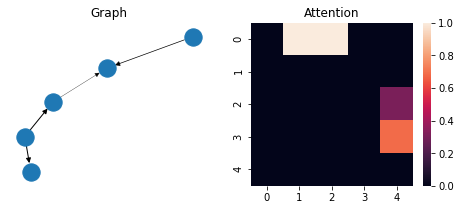

In [527]:
def attention_dgl_gsddmm(g):
    q = g.ndata['q']
    k = g.ndata['k']
    v = g.ndata['v']
    d_k = q.size(-1)
    score = Fops.edge_softmax(g, Fops.v_dot_u(g, q, k) / d_k**0.5)
    out = Fops.u_mul_e_sum(g, v, score)
    return out, score

g = init_g(3)
out0, attn0 = attention(g)
out1, attn1 = attention_dgl_gsddmm(g)

assert torch.allclose(out0, out1)
assert torch.allclose(attn0, attn1)
print(out1)
print(attn1)

plot_graph_and_attn(g, attn0)

**Attention with half-complete graph**

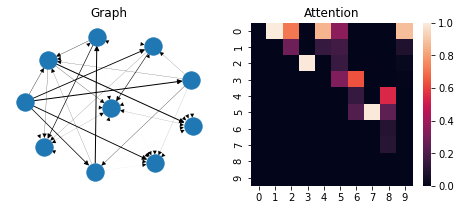

In [542]:
def init_complete_g(n_nodes, d_k, half=False):
    edges = torch.combinations(torch.arange(n_nodes), with_replacement=False).T
    edges = edges[:, :]
    
    g = dgl.graph((edges[0], edges[1]))
    if not half:
        g.add_edges(edges[1], edges[0])
    n = g.number_of_nodes()
    x = torch.randn(3, n, d_k) * 2.
    g.ndata['k'] = x[0]
    g.ndata['q'] = x[1]
    g.ndata['v'] = x[2]
    return g

g = init_complete_g(10, 7, half=True)
out, attn = attention_dgl_gsddmm(g)
plot_graph_and_attn(g, attn)

### Graph Transformer Module